# Imports

In [33]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import col, sum, count
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
import pyspark.pandas as ps

import plotly.express as px

# Create spark session

In [2]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.cores", "2") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

print("Spark session created with custom configurations.")

Spark session created with custom configurations.


# Import data

In [3]:
dfs_stress=spark.read.csv('data/stress_detection.csv', header=True, inferSchema=True)

In [4]:
dfs_stress.printSchema()

root
 |-- participant_id: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- PSS_score: integer (nullable = true)
 |-- Openness: double (nullable = true)
 |-- Conscientiousness: double (nullable = true)
 |-- Extraversion: double (nullable = true)
 |-- Agreeableness: double (nullable = true)
 |-- Neuroticism: double (nullable = true)
 |-- sleep_time: double (nullable = true)
 |-- wake_time: double (nullable = true)
 |-- sleep_duration: double (nullable = true)
 |-- PSQI_score: integer (nullable = true)
 |-- call_duration: double (nullable = true)
 |-- num_calls: integer (nullable = true)
 |-- num_sms: integer (nullable = true)
 |-- screen_on_time: double (nullable = true)
 |-- skin_conductance: double (nullable = true)
 |-- accelerometer: double (nullable = true)
 |-- mobility_radius: double (nullable = true)
 |-- mobility_distance: double (nullable = true)



In [5]:
dfs_stress.show()

+--------------+---+---------+-----------+-----------------+------------+-------------+-----------+-----------+-----------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+
|participant_id|day|PSS_score|   Openness|Conscientiousness|Extraversion|Agreeableness|Neuroticism| sleep_time|  wake_time|sleep_duration|PSQI_score|call_duration|num_calls|num_sms|screen_on_time|skin_conductance|accelerometer|mobility_radius|mobility_distance|
+--------------+---+---------+-----------+-----------------+------------+-------------+-----------+-----------+-----------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+
|             1|  1|       34| 2.32273211|      4.332193156| 1.185877791|  1.570213395|3.782093775|7.726792258|  5.1906604|   6.572068901|         1|  3.924526753|       12|     32|   10.70371376|     3.115729826| 

#### Persist dataframe

In [6]:
dfs_stress.persist(StorageLevel.MEMORY_AND_DISK).count()

3000

# Nettoyage des données

In [7]:
missing_counts = dfs_stress.select([sum(col(c).isNull().cast("int")).alias(c) for c in dfs_stress.columns])
missing_counts.show()

+--------------+---+---------+--------+-----------------+------------+-------------+-----------+----------+---------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+
|participant_id|day|PSS_score|Openness|Conscientiousness|Extraversion|Agreeableness|Neuroticism|sleep_time|wake_time|sleep_duration|PSQI_score|call_duration|num_calls|num_sms|screen_on_time|skin_conductance|accelerometer|mobility_radius|mobility_distance|
+--------------+---+---------+--------+-----------------+------------+-------------+-----------+----------+---------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+
|             0|  0|        0|       0|                0|           0|            0|          0|         0|        0|             0|         0|            0|        0|      0|             0|               0|            0|           

Il n'y a pas de données manquantes

In [8]:
duplicate_counts = dfs_stress.groupBy("participant_id", "day").count()
duplicates = duplicate_counts.filter(col("count") > 1)
duplicates.show()

+--------------+---+-----+
|participant_id|day|count|
+--------------+---+-----+
+--------------+---+-----+



Il n'y a pas de doublons

#### Valeurs aberrantes

In [9]:
# participant_id : 1 à 100
out_of_range_participant_id = dfs_stress.filter((col("participant_id") < 1) | (col("participant_id") > 100))
out_of_range_participant_id.show()

# day : 1 à 30
out_of_range_day = dfs_stress.filter((col("day") < 1) | (col("day") > 30))
out_of_range_day.show()

# PSS_score : 10 à 40
out_of_range_pss_score = dfs_stress.filter((col("PSS_score") < 10) | (col("PSS_score") > 40))
out_of_range_pss_score.show()

# Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism : 1.0 à 5.0
traits = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]
for trait in traits:
    dfs_stress.filter((col(trait) < 1.0) | (col(trait) > 5.0)).show()

# sleep_time : 5.0 à 9.0
out_of_range_sleep_time = dfs_stress.filter((col("sleep_time") < 5.0) | (col("sleep_time") > 9.0))
out_of_range_sleep_time.show()

# wake_time : 5.0 à 9.0
out_of_range_wake_time = dfs_stress.filter((col("wake_time") < 5.0) | (col("wake_time") > 9.0))
out_of_range_wake_time.show()

# sleep_duration : 6.0 à 9.0
out_of_range_sleep_duration = dfs_stress.filter((col("sleep_duration") < 6.0) | (col("sleep_duration") > 9.0))
out_of_range_sleep_duration.show()

# PSQI_score : 1 à 5
out_of_range_psqi_score = dfs_stress.filter((col("PSQI_score") < 1) | (col("PSQI_score") > 5))
out_of_range_psqi_score.show()

# call_duration : 0 à 60
out_of_range_call_duration = dfs_stress.filter((col("call_duration") < 0) | (col("call_duration") > 60))
out_of_range_call_duration.show()

# num_calls : 0 à 20
out_of_range_num_calls = dfs_stress.filter((col("num_calls") < 0) | (col("num_calls") > 20))
out_of_range_num_calls.show()

# num_sms : 0 à 50
out_of_range_num_sms = dfs_stress.filter((col("num_sms") < 0) | (col("num_sms") > 50))
out_of_range_num_sms.show()

# screen_on_time : 1.0 à 12.0
out_of_range_screen_on_time = dfs_stress.filter((col("screen_on_time") < 1.0) | (col("screen_on_time") > 12.0))
out_of_range_screen_on_time.show()

# skin_conductance : 0.5 à 5.0 µS
out_of_range_skin_conductance = dfs_stress.filter((col("skin_conductance") < 0.5) | (col("skin_conductance") > 5.0))
out_of_range_skin_conductance.show()

# accelerometer : 0.1 à 2.5 g
out_of_range_accelerometer = dfs_stress.filter((col("accelerometer") < 0.1) | (col("accelerometer") > 2.5))
out_of_range_accelerometer.show()

# mobility_radius : 0.1 à 1.5 km
out_of_range_mobility_radius = dfs_stress.filter((col("mobility_radius") < 0.1) | (col("mobility_radius") > 1.5))
out_of_range_mobility_radius.show()

# mobility_distance : 0.5 à 5.0 km
out_of_range_mobility_distance = dfs_stress.filter((col("mobility_distance") < 0.5) | (col("mobility_distance") > 5.0))
out_of_range_mobility_distance.show()



+--------------+---+---------+--------+-----------------+------------+-------------+-----------+----------+---------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+
|participant_id|day|PSS_score|Openness|Conscientiousness|Extraversion|Agreeableness|Neuroticism|sleep_time|wake_time|sleep_duration|PSQI_score|call_duration|num_calls|num_sms|screen_on_time|skin_conductance|accelerometer|mobility_radius|mobility_distance|
+--------------+---+---------+--------+-----------------+------------+-------------+-----------+----------+---------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+
+--------------+---+---------+--------+-----------------+------------+-------------+-----------+----------+---------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+-----------

Il n'y pas de valeurs aberrantes

# 3. Normalisation des variables numériques

on supprime les colonnes inutiles

In [10]:
dfs_stress = dfs_stress.drop("participant_id", "day")

### Assembler les colonnes numériques pour la normalisation

In [11]:
numeric_cols = ["PSS_score", "Openness", "Conscientiousness", "Extraversion", 
                "Agreeableness", "Neuroticism", "sleep_time", "wake_time", 
                "sleep_duration", "PSQI_score", "call_duration", "num_calls", 
                "num_sms", "screen_on_time", "skin_conductance", "accelerometer", 
                "mobility_radius", "mobility_distance"]

In [12]:
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
dfs_stress = assembler.transform(dfs_stress)

In [13]:
dfs_stress.persist(StorageLevel.MEMORY_AND_DISK).count()

3000

### Appliquer MinMaxScaler pour normaliser les données

In [14]:
scaler = MinMaxScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")
scaler_model = scaler.fit(dfs_stress)
dfs_stress = scaler_model.transform(dfs_stress)

In [15]:
dfs_stress.persist(StorageLevel.MEMORY_AND_DISK).count()

3000

###  Assembler toutes les caractéristiques en une seule colonne `features`

In [16]:
feature_cols = ["scaled_numeric_features"]
assembler_final = VectorAssembler(inputCols=feature_cols, outputCol="features")
dfs_stress = assembler_final.transform(dfs_stress)

In [17]:
dfs_regression=dfs_stress.select("features", "PSS_score")
dfs_regression.persist(StorageLevel.MEMORY_AND_DISK).count()

3000

In [18]:
dfs_regression.show()

+--------------------+---------+
|            features|PSS_score|
+--------------------+---------+
|[0.82758620689655...|       34|
|[0.93103448275862...|       37|
|[0.68965517241379...|       30|
|[0.20689655172413...|       16|
|[0.75862068965517...|       32|
|[0.62068965517241...|       28|
|[1.0,0.4730534583...|       39|
|[0.31034482758620...|       19|
|[0.41379310344827...|       22|
|[0.17241379310344...|       15|
|[0.58620689655172...|       27|
|[0.03448275862068...|       11|
|[0.0,0.2365329049...|       10|
|[0.03448275862068...|       11|
|[0.31034482758620...|       19|
|[0.41379310344827...|       22|
|[0.24137931034482...|       17|
|[0.13793103448275...|       14|
|[0.44827586206896...|       23|
|[0.89655172413793...|       36|
+--------------------+---------+
only showing top 20 rows



In [19]:
dfs_stress.show()

+---------+-----------+-----------------+------------+-------------+-----------+-----------+-----------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+--------------------+-----------------------+--------------------+
|PSS_score|   Openness|Conscientiousness|Extraversion|Agreeableness|Neuroticism| sleep_time|  wake_time|sleep_duration|PSQI_score|call_duration|num_calls|num_sms|screen_on_time|skin_conductance|accelerometer|mobility_radius|mobility_distance|    numeric_features|scaled_numeric_features|            features|
+---------+-----------+-----------------+------------+-------------+-----------+-----------+-----------+--------------+----------+-------------+---------+-------+--------------+----------------+-------------+---------------+-----------------+--------------------+-----------------------+--------------------+
|       34| 2.32273211|      4.332193156| 1.185877791|  1.570213395|3.782

# Analyse Exploratoire des Données

### Calculer les statistiques descriptives pour toutes les colonnes numériques

In [20]:
dfs_stress.describe().show()

+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|summary|        PSS_score|         Openness| Conscientiousness|      Extraversion|     Agreeableness|       Neuroticism|        sleep_time|         wake_time|    sleep_duration|        PSQI_score|     call_duration|        num_calls|           num_sms|   screen_on_time|  skin_conductance|     accelerometer|   mobility_radius|mobility_distance|
+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+----------------

### Visualisation exploratoire

In [23]:
dfs_stress_ps = dfs_stress.to_pandas_on_spark()

c:\python\lib\site-packages\pyspark\sql\dataframe.py:5725: FutureWarning:

DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.



#### Continuous variables

In [40]:
variables_continues = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism", 
                       "sleep_time", "wake_time", "sleep_duration", "call_duration", 
                       "screen_on_time", "skin_conductance", "accelerometer", 
                       "mobility_radius", "mobility_distance"]

In [ ]:
for var in variables_continues:
    fig = dfs_stress_ps.plot.scatter(x=var, y="PSS_score", title=f"Relation entre {var} et PSS_score")
    fig.show()

#### Non continuous variables

In [29]:
variables_discretes = ["PSQI_score", "num_calls", "num_sms"]

##### Box plot

In [34]:
for var in variables_discretes:
    # Calcul de la moyenne de PSS_score pour chaque catégorie de la variable discrète
    bar_data = dfs_stress_ps.groupby(var)["PSS_score"].mean().reset_index()
    fig = px.bar(bar_data, x=var, y="PSS_score", title=f"Moyenne de PSS_score par {var}")
    fig.show()

c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.

c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.

c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



##### Violin plot

In [35]:
for var in variables_discretes:
    fig = px.violin(dfs_stress_ps.to_pandas(), y="PSS_score", x=var, 
                    box=True, points="all", title=f"Distribution de PSS_score par {var}",
                    labels={"PSS_score": "PSS_score", var: var})
    fig.show()

c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



#### Histogrammes variables

In [36]:
variables = ["PSS_score", "Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism",
             "sleep_time", "wake_time", "sleep_duration", "PSQI_score", "call_duration",
             "num_calls", "num_sms", "screen_on_time", "skin_conductance", 
             "accelerometer", "mobility_radius", "mobility_distance"]

In [37]:
for var in variables:
    fig = px.histogram(dfs_stress_ps.to_pandas(), x=var, title=f"Distribution de {var}")
    fig.show()

c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



### Matrice de corrélation

In [43]:
pip install seaborn

     -------------------------------------- 294.9/294.9 KB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 7.8/7.8 MB 5.7 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 9.1 MB/s eta 0:00:00
     ------------------------------------- 211.8/211.8 KB 12.6 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 4.9 MB/s eta 0:00:00
     -------------------------------------- 106.9/106.9 KB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 KB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\python\python.exe -m pip install --upgrade pip' command.


c:\python\lib\site-packages\pyspark\pandas\utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



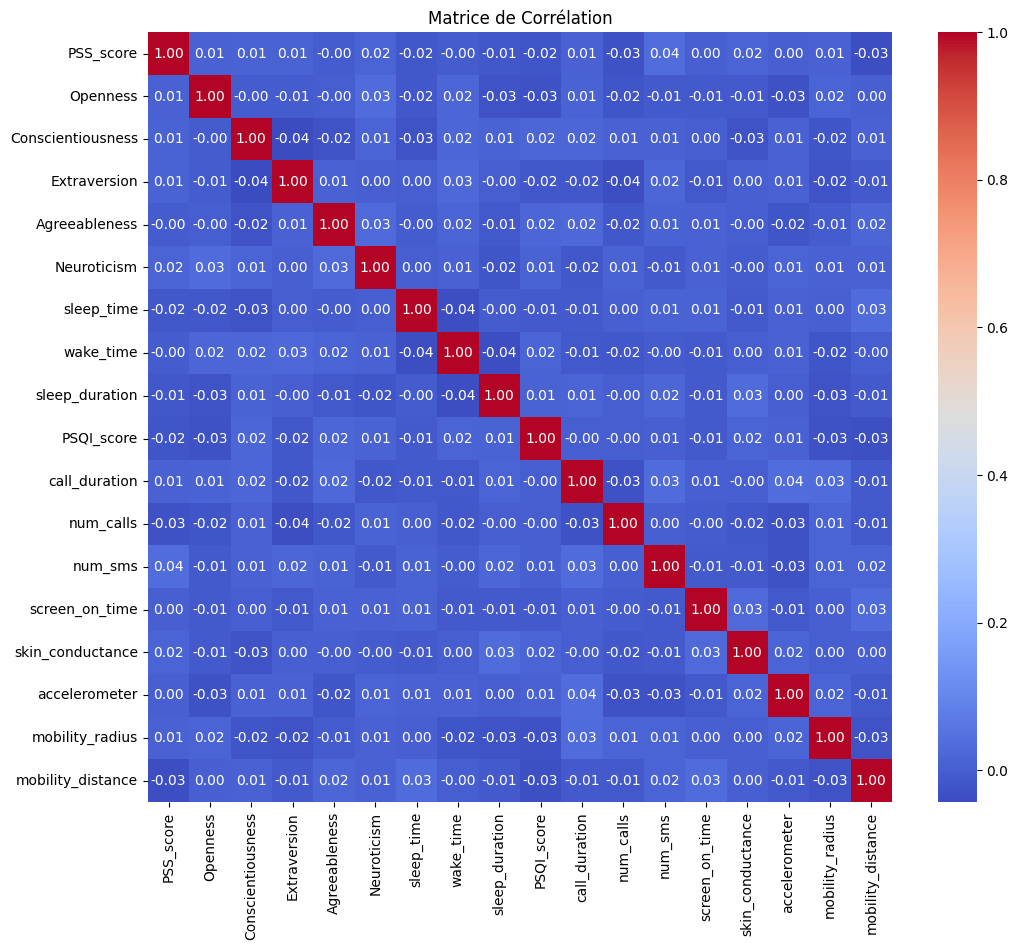

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir le DataFrame en Pandas pour calculer les corrélations
dfs_stress_pandas = dfs_stress_ps.to_pandas()

# Calculer la matrice de corrélation
correlation_matrix = dfs_stress_pandas[variables].corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

### Analyse de la Matrice de Corrélation

La matrice de corrélation ci-dessous montre les relations entre les différentes variables de notre dataset. Voici les principaux points à noter :

1. **Corrélations faibles entre les variables** : La majorité des coefficients de corrélation sont proches de zéro, ce qui indique une très faible corrélation entre les variables. Cela suggère que les variables du dataset sont relativement indépendantes les unes des autres, sans association forte.

2. **Corrélation de `PSS_score`** : `PSS_score` n’a pas de corrélations fortes avec les autres variables explicatives. Cela signifie qu'aucune variable ne semble fortement associée au score de stress perçu (`PSS_score`), ce qui pourrait compliquer la tâche de prédiction de cette variable cible.

3. **Autocorrélations** : Comme attendu, les valeurs diagonales sont à 1, car chaque variable est parfaitement corrélée avec elle-même.

4. **Observations supplémentaires** : Quelques corrélations faibles sont visibles, comme entre `num_calls` et `num_sms`. Bien que cette corrélation soit modeste, elle pourrait suggérer une légère relation entre ces deux variables.

En conclusion, cette matrice de corrélation ne révèle pas de tendances claires ou de relations fortes entre `PSS_score` et les autres variables. Si l'objectif est de prédire `PSS_score`, il pourrait être nécessaire d'explorer des transformations non linéaires ou des interactions entre les variables pour identifier des schémas potentiellement cachés dans les données.

### Donc pas de régression linéaire